# CEO-Request Challenge

### Unit Economics (detailed)

#### Revenue

    Olist takes a 10% cut on the product price (excl. freight) of each order delivered.
    Olist charges 80 BRL by month per seller.

#### Cost

In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
    
    review_score: cost (BRL)
    1 star: 100
    2 stars: 50
    3 stars: 40
    4 stars: 0
    5 stars: 0


#### IT Cost

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).

    For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.

The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

# **Should Olist remove underperforming sellers from its marketplace?** 🕵🏻

In doing so, we want to **improve**:

- net profit
- average review score (aka customer satisfaction)

## Answer: Yes.

Remove the bottom ~300 sellers that are contributing negatively to both:
- Olist's net profit
- Olist's reputation (by lowering overall average seller review score)

## How did we come to this conclusion?

**<center>'What-if' analysis</center>**

<center>What if Olist had never accepted certain underperforming sellers in the first place?</center>

### Definitions: what criteria do we use to define an _underperforming_ seller?

We will **simplify** seller performance to account for as many parameters as possible by quantifying:

- **revenue** brought to Olist
    - 10% of sales made by seller
    - 80 BRL per month platform fee to Olist

- **costs** incurred to Olist
    1. review-based
        - 100 BRL per 1-star review
        - 50 BRL per 2-star review
        - 40 BRL per 3-star review
    2. order-based
        - IT cost proportional to volume of orders brought in by the seller

An underperforming seller would be one that brings more costs than revenue to Olist (negative profit).

### Procedure


*Maximizing net profit*

1. calculate each seller's net profit contribution to Olist


2. simulate new net profit by removing sellers one by one, starting with lowest


3. find the optimal number of sellers removed where **Olist's net profit is maximized**  

*Adding in customer satisfaction considerations*

4. observe effect on overall average seller review as sellers are removed


5. is there an optimum point for both net profit and overall average seller review?

In [2]:
from olist.seller import Seller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## Import data

In [ ]:
sellers = Seller().get_training_data()
orders = Seller().order.get_training_data(with_distance_seller_customer=True)

## Calculate olist revenue, cost, & profit

In [4]:
# compute revenue each seller brings to Olist
sellers['olist_revenue'] = sellers['months_on_olist']*80 + sellers['sales']*.1

# compute cost each seller brings to Olist
order_items = Seller().data['order_items']
order_items = order_items.filter(['order_id', 'seller_id']).drop_duplicates()
orders_merged = orders.merge(order_items, on='order_id')
orders_merged['cost'] = orders_merged['review_score'].map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
orders_merged['olist_cost'] = orders_merged.apply(lambda row: row['cost'] / row['number_of_sellers'], axis=1)
olist_cost = orders_merged.groupby('seller_id')[['olist_cost']].sum()
sellers_pl = sellers.merge(olist_cost, on='seller_id')

# compute profit each seller brings to Olist
sellers_pl['olist_profit'] = sellers_pl['olist_revenue'] - sellers_pl['olist_cost']

## Profit to-date

In [5]:
#calculate IT scaling factor
IT_sf = 500_000 / (len(orders) ** 0.5)

In [6]:
revenue_t = sellers_pl['olist_revenue'].sum()
profit_t = sellers_pl['olist_profit'].sum()
orders_t = orders.query("order_status == 'delivered'").order_id.count()
IT_t = IT_sf * (orders_t ** 0.5)
net_profit = profit_t - IT_t
net_profit_margin = net_profit / revenue_t

print(f'Revenue = {revenue_t}')
print(f'Profit = {profit_t}')
print(f'Number of orders = {orders_t}')
print(f'IT cost = {IT_t}')
print(f'Net profit = {net_profit}')
print(f'Net profit margin = {round(net_profit_margin * 100, 2)}%')

Revenue = 2782658.293
Profit = 1383388.293
Number of orders = 95872
IT cost = 499999.99999999994
Net profit = 883388.2930000001
Net profit margin = 31.75%


### The current state (profit to-date)



Summary | Value
:--- | ---:
Number of orders | 95,872
Revenue | 2,782,658
Net Profit | 883,388
Net Profit Margin | 31.75%

## Exploring underperforming sellers

### Removing sellers by lowest profit

In [7]:
sellers_pl_sorted = sellers_pl.sort_values('olist_profit', ignore_index=True)
n_orders = orders.query("order_status == 'delivered'").order_id.count()

# calculate new profits based on number of sellers removed
new_profits = profit_t - sellers_pl_sorted.olist_profit.cumsum() - IT_sf * ((n_orders - sellers_pl_sorted.n_orders.cumsum()) ** 0.5)
new_profits = pd.concat([pd.Series([net_profit]), new_profits], ignore_index=True)
x1_max = new_profits.idxmax()
y1_max = new_profits.max()

# calculate new profits margin
new_profits_margin = new_profits / (pd.concat([pd.Series([revenue_t]), revenue_t - sellers_pl_sorted.olist_revenue.cumsum()], ignore_index=True))

# calculate new avg review score based on number of sellers removed
orders_removed = np.arange(1, len(sellers_pl_sorted), 1)
new_avg_review = []
for i in orders_removed:
    new_avg_review.append(sellers_pl_sorted[i:].review_score.mean())
avg_review_ymax = max(new_avg_review[:750])
avg_review_xmax = new_avg_review.index(avg_review_ymax)

#### What happens to Olist net profit as we start to remove sellers, starting with the most underperforming (negative) and slowly moving upwards?

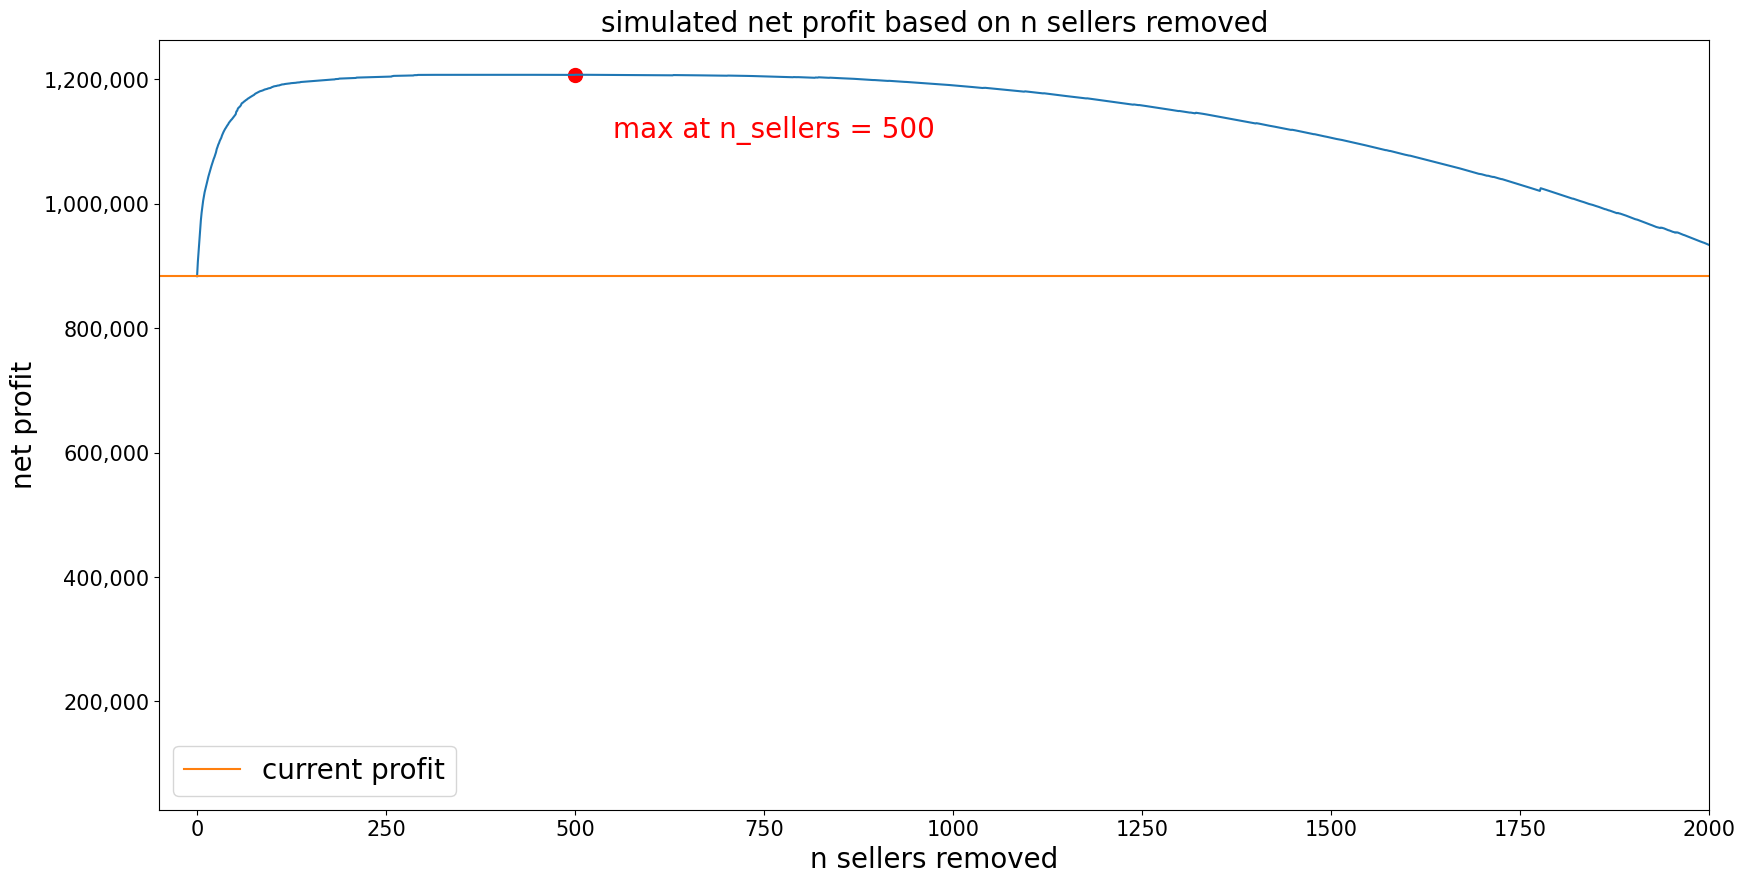

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10))

# plot net profit vs. sellers removed
new_profits.plot(ax=ax1, label='__nolegend__')
ax1.scatter(x1_max, y1_max, color='red', s=100)
#ax.scatter(avg_review_xmax, new_profits[avg_review_xmax], color='green')
ax1.plot([-50, 2000], [net_profit]*2, label='current profit')
ax1.set_xlabel('n sellers removed', fontsize=20)
ax1.set_ylabel('net profit', fontsize=20)
ax1.set_xlim([-50,2000])
ax1.set_title('simulated net profit based on n sellers removed', fontsize=20)
ax1.tick_params(axis='both', labelsize=15)
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.legend(loc='lower left', fontsize=20)
ax1.text(x1_max + 50, y1_max - 100000, 'max at n_sellers = 500', fontsize=20, color='r')

plt.show();

#### What is the effect on net profit margin?

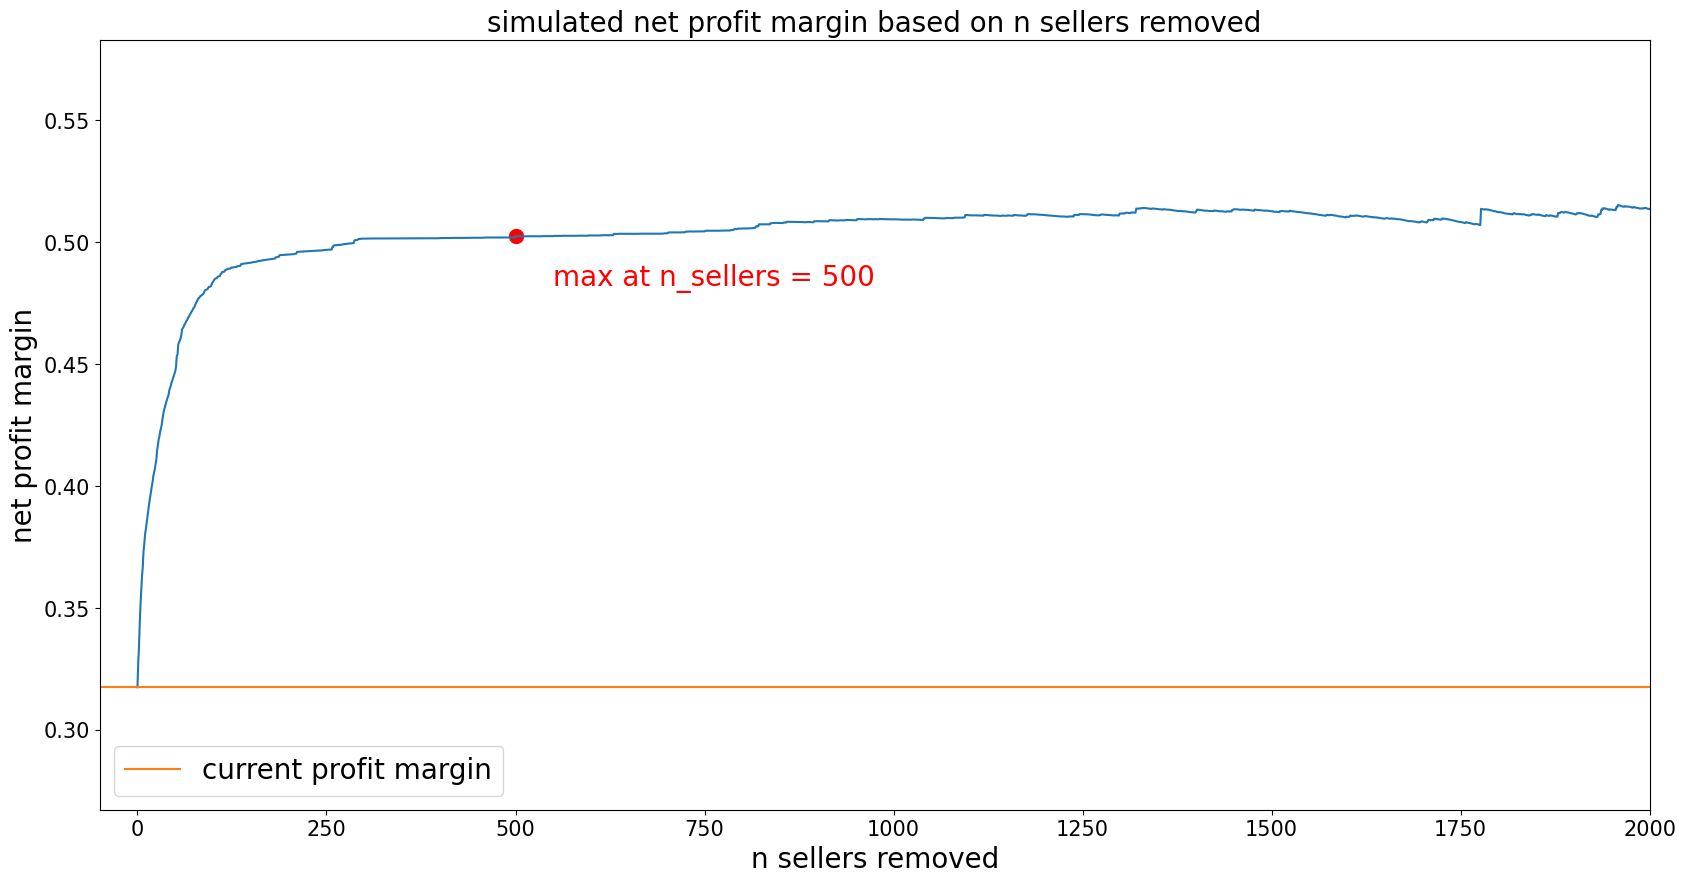

In [51]:
fig, ax2 = plt.subplots(1, 1, figsize=(20,10))

# plot net profit margin vs. sellers removed
new_profits_margin.plot(ax=ax2, label='__nolegend__')
ax2.scatter(x1_max, new_profits_margin[x1_max], color='red', s=100)
#ax2.scatter(avg_review_xmax, new_profits_margin[avg_review_xmax], color='green')
ax2.plot([-50, 2000], [net_profit_margin]*2, label='current profit margin')
ax2.set_xlabel('n sellers removed', fontsize=20)
ax2.set_ylabel('net profit margin', fontsize=20)
ax2.set_xlim([-50,2000])
ax2.set_title('simulated net profit margin based on n sellers removed', fontsize=20)
ax2.tick_params(axis='both', labelsize=15)
ax2.legend(loc='lower left', fontsize=20)
ax2.text(x1_max + 50, new_profits_margin[x1_max] - 0.02, 'max at n_sellers = 500', fontsize=20, color='r')

plt.show()

#### How does removing these sellers affect our overall average seller review?

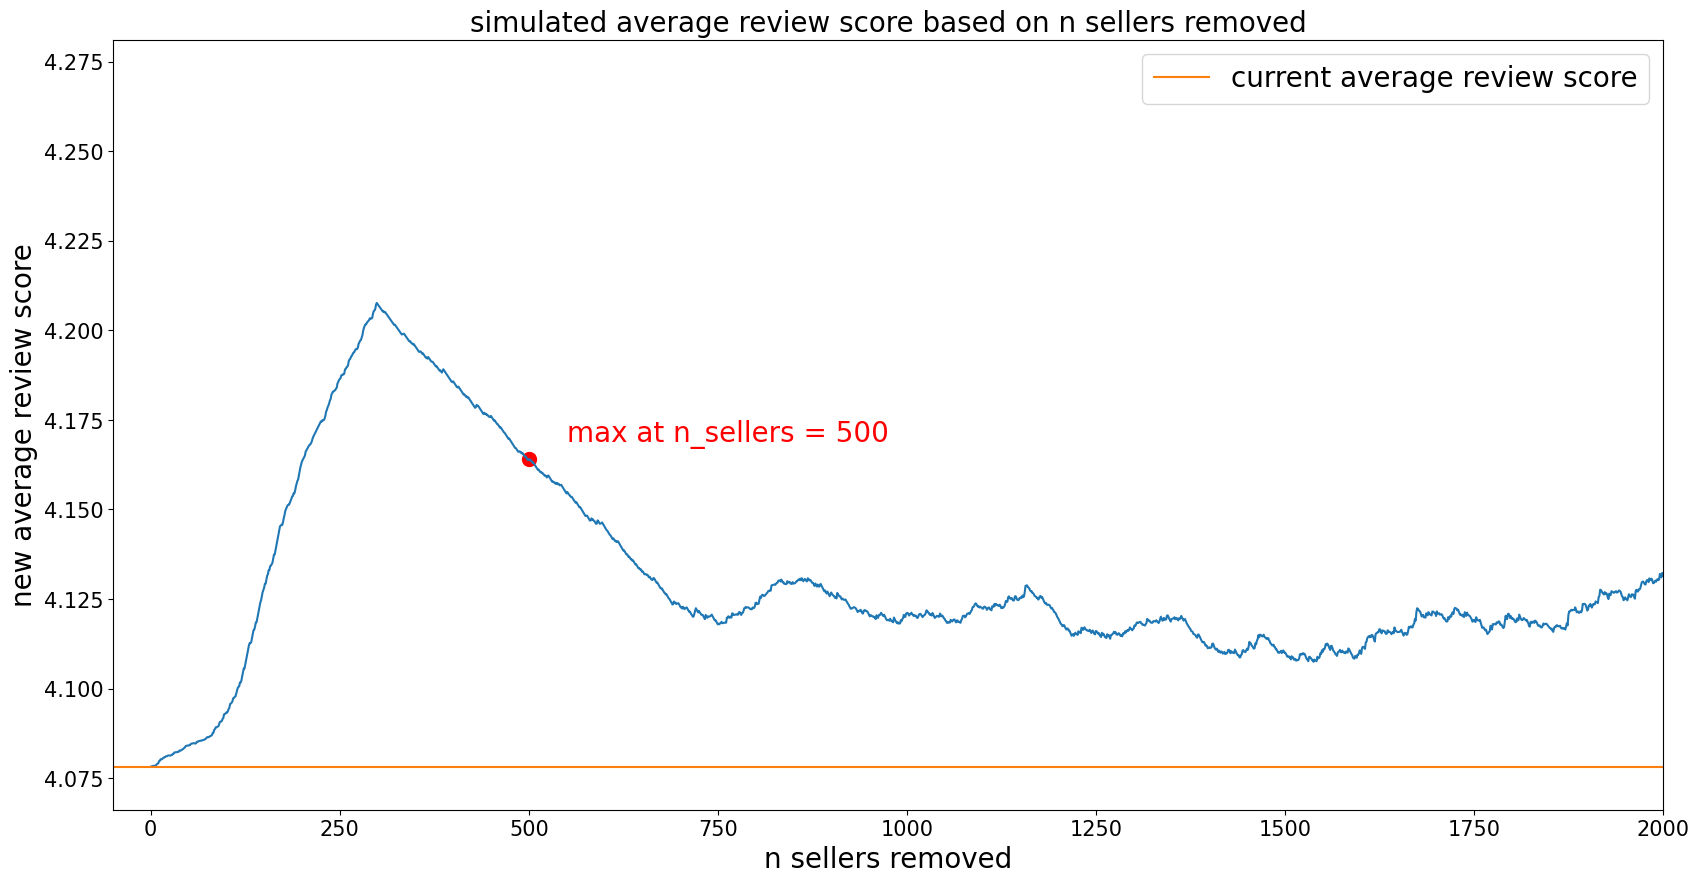

In [55]:
fig, ax3 = plt.subplots(1, 1, figsize=(20,10))

#plot avg review score vs. sellers removed
ax3.plot(orders_removed, new_avg_review)
ax3.scatter(x1_max, new_avg_review[x1_max], color='red', s=100)
ax3.plot([-50, 2000], [sellers_pl.review_score.mean()]*2, label='current average review score')
#ax3.scatter(avg_review_xmax, avg_review_ymax, color='green')
ax3.set_xlabel('n sellers removed', fontsize=20)
ax3.set_ylabel('new average review score', fontsize=20)
ax3.set_xlim([-50,2000])
ax3.legend(loc='upper right', fontsize=20)
ax3.set_title('simulated average review score based on n sellers removed', fontsize=20)
ax3.tick_params(axis='both', labelsize=15)
ax3.text(x1_max + 50, new_avg_review[x1_max] + 0.005, 'max at n_sellers = 500', fontsize=20, color='r')


plt.show()

#### The maximum for simulated average review scores actually occurs earlier at n = 298.

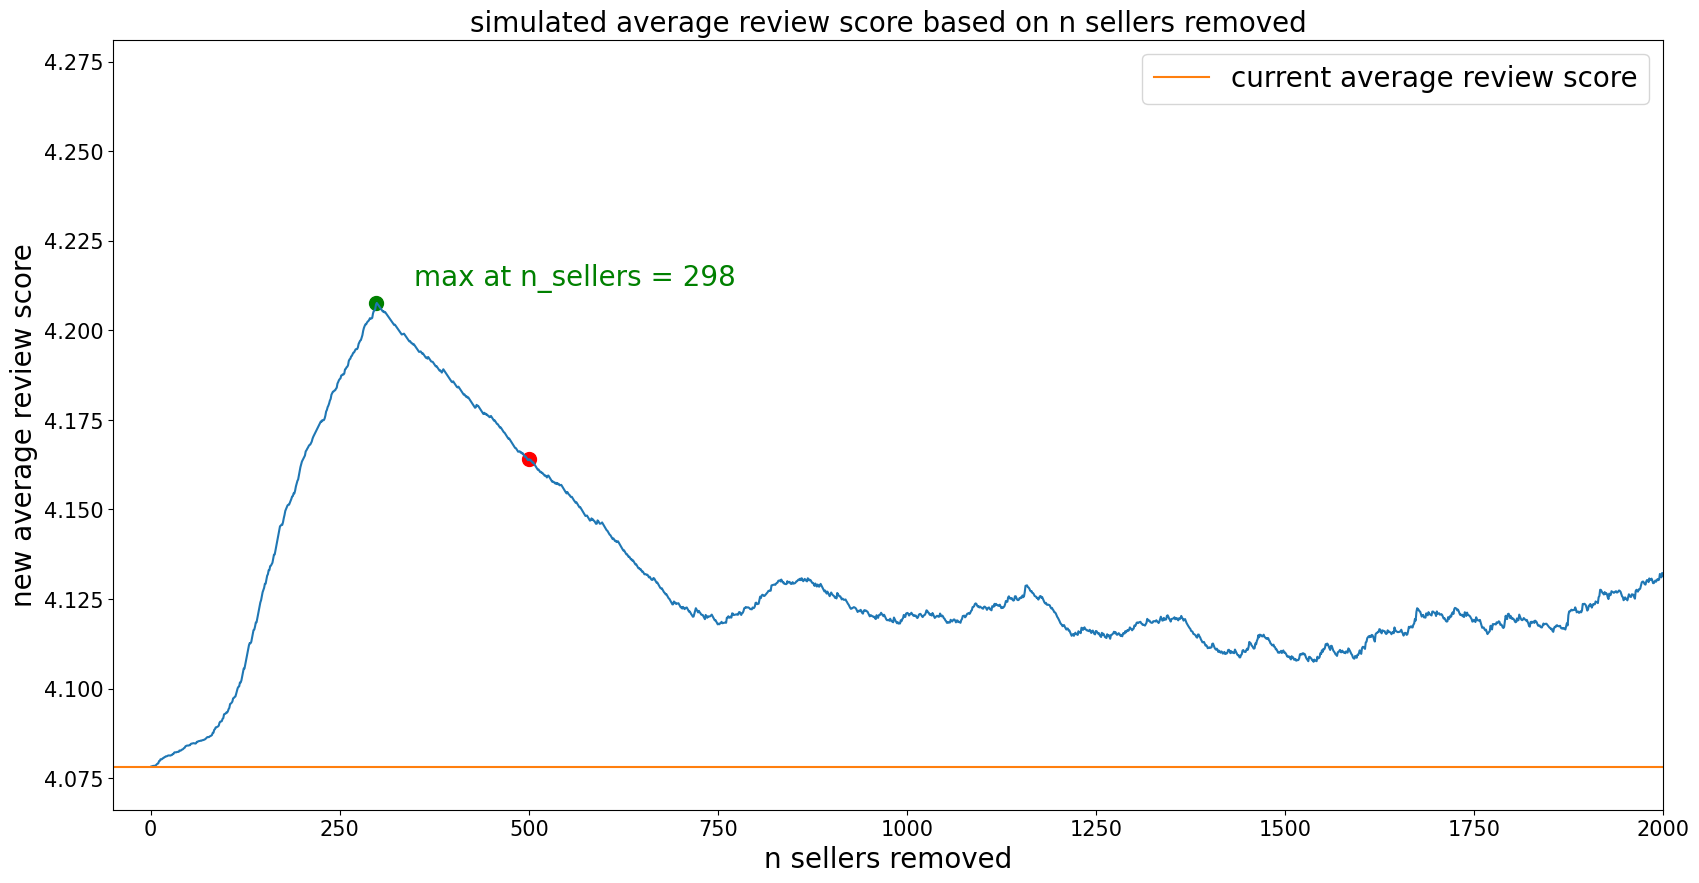

In [80]:
fig, ax3 = plt.subplots(1, 1, figsize=(20,10))

#plot avg review score vs. sellers removed
ax3.plot(orders_removed, new_avg_review)
ax3.scatter(x1_max, new_avg_review[x1_max], color='red', s=100)
ax3.plot([-50, 2000], [sellers_pl.review_score.mean()]*2, label='current average review score')
ax3.scatter(avg_review_xmax, avg_review_ymax, color='green', s=100)
ax3.set_xlabel('n sellers removed', fontsize=20)
ax3.set_ylabel('new average review score', fontsize=20)
ax3.set_xlim([-50,2000])
ax3.legend(loc='upper right', fontsize=20)
ax3.set_title('simulated average review score based on n sellers removed', fontsize=20)
ax3.tick_params(axis='both', labelsize=15)
ax3.text(avg_review_xmax + 50, avg_review_ymax + 0.005, 'max at n_sellers = 298', fontsize=20, color='g')


plt.show()

Since we are also thinking about **maximizing average review score** in addition to **maximizing profit**, what does removing n = 298 sellers look like on our previous profit and profit margin graphs?

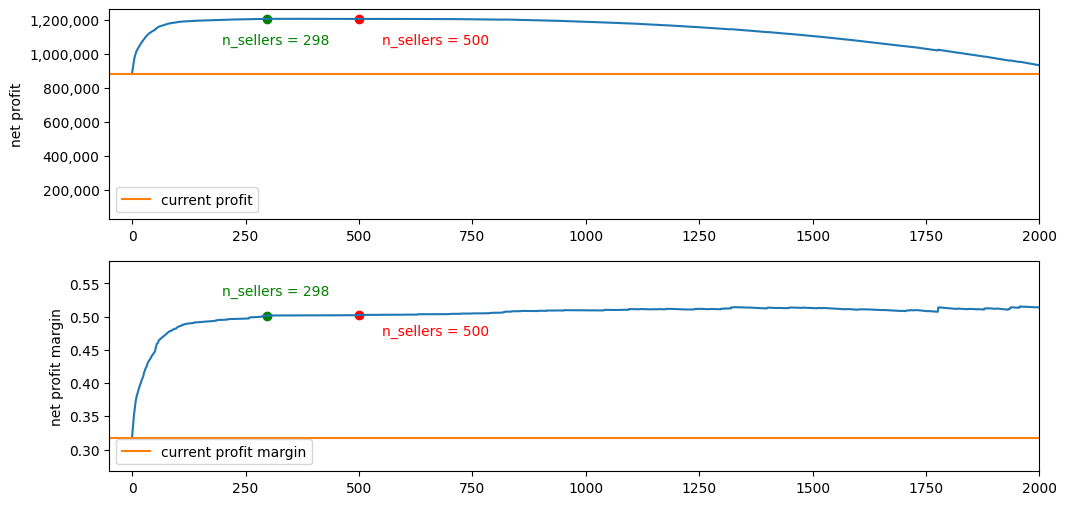

In [87]:
fig, (ax4, ax5) = plt.subplots(2, 1, figsize=(12,6))

# plot net profit vs. sellers removed
new_profits.plot(ax=ax4, label='__nolegend__')
ax4.scatter(x1_max, y1_max, color='red')
ax4.scatter(avg_review_xmax, new_profits[avg_review_xmax], color='green')
ax4.plot([-50, 2000], [net_profit]*2, label='current profit')
#ax4.set_xlabel('n sellers removed')
ax4.set_ylabel('net profit')
ax4.set_xlim([-50,2000])
ax4.legend(loc='lower left')
ax4.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax4.text(x1_max + 50, y1_max - 150000, 'n_sellers = 500', fontsize=10, color='r')
ax4.text(avg_review_xmax - 100, new_profits[avg_review_xmax] - 150000, 'n_sellers = 298', fontsize=10, color='g')

# plot net profit margin vs. sellers removed
new_profits_margin.plot(ax=ax5, label='__nolegend__')
ax5.scatter(x1_max, new_profits_margin[x1_max], color='red')
ax5.scatter(avg_review_xmax, new_profits_margin[avg_review_xmax], color='green')
ax5.plot([-50, 2000], [net_profit_margin]*2, label='current profit margin')
#ax5.set_xlabel('n sellers removed')
ax5.set_ylabel('net profit margin')
ax5.set_xlim([-50,2000])
ax5.legend(loc='lower left')
ax5.text(x1_max + 50, new_profits_margin[x1_max] - 0.03, 'n_sellers = 500', fontsize=10, color='r')
ax5.text(avg_review_xmax - 100, new_profits_margin[avg_review_xmax] + 0.03, 'n_sellers = 298', fontsize=10, color='g')

plt.show()

Removing 298 sellers vs. 500 sellers yields **nearly no difference** in simulated profit and profit margin.


Maybe we can just remove n = 298 sellers as our optimum.  

In [90]:
compare_sellers_n = [avg_review_xmax, x1_max]
compare_sellers_n.reverse()
compare_net_p = [int(new_profits[compare_sellers_n[0]]), int(new_profits[compare_sellers_n[1]])]
compare_net_pm = [round(new_profits_margin[compare_sellers_n[0]], 4), round(new_profits_margin[compare_sellers_n[1]], 4)]
compare_avg_rev = [round(new_avg_review[compare_sellers_n[0]], 2), round(new_avg_review[compare_sellers_n[1]], 2)]
temp_list = [compare_net_p, compare_net_pm, compare_avg_rev]

compare_df = pd.DataFrame(columns=['n = 500', 'n = 298'], data=temp_list)
compare_df.index = ['profit', 'profit margin', 'avg review score']
compare_df['change'] = round(compare_df['n = 298']/compare_df['n = 500'] - 1, 4)
d = {'n = 500': '{:,.4f}', 'n = 298': '{:,.4f}', 'change': '{:.2%}'}
compare_df.style.applymap(lambda x : 'color: red' if x < 0 else 'color: black').format(d)

,n = 500,n = 298,change
profit,"1,207,138.0000","1,206,912.0000",-0.02%
profit margin,0.5025,0.5015,-0.20%
avg review score,4.1600,4.2100,1.20%


By choosing n = 298 over n = 500, we observe:
- **less than 1% loss** in profit and profit margin
- **1.2% gain** in average review score

### Removing sellers by average review score threshold
- remove sellers based on avg review_score up to a threshold
- plot # of sellers removed vs new net profit margin

In [281]:
review_score_threshold = np.arange(1,3.01,.02)
new_profit_margin = []
new_profit = []
n_sellers = []
new_review = []

#loop to calculate new profit margin, number of remaining sellers every time sellers under an avg review score threshold is removed
for i in review_score_threshold:
    x_revenue = sellers_pl[sellers_pl['review_score'] <= i]['olist_revenue'].sum()
    x_profit = sellers_pl[sellers_pl['review_score'] <= i]['olist_profit'].sum()
    new_n_orders = orders.query("order_status == 'delivered'").order_id.count() - sellers_pl[sellers_pl['review_score'] <= i]['n_orders'].sum()
    new_IT = IT_sf * (new_n_orders ** 0.5)
    new_pm = (profit_t - x_profit - new_IT) / (revenue_t - x_revenue)
    new_profit_margin.append(new_pm)
    new_profit.append(profit_t - x_profit - new_IT)
    n_sellers.append(len(sellers_pl) - len(sellers_pl[sellers_pl['review_score'] <= i]))
    new_review.append(sellers_pl[sellers_pl['review_score'] > i]['review_score'].mean())

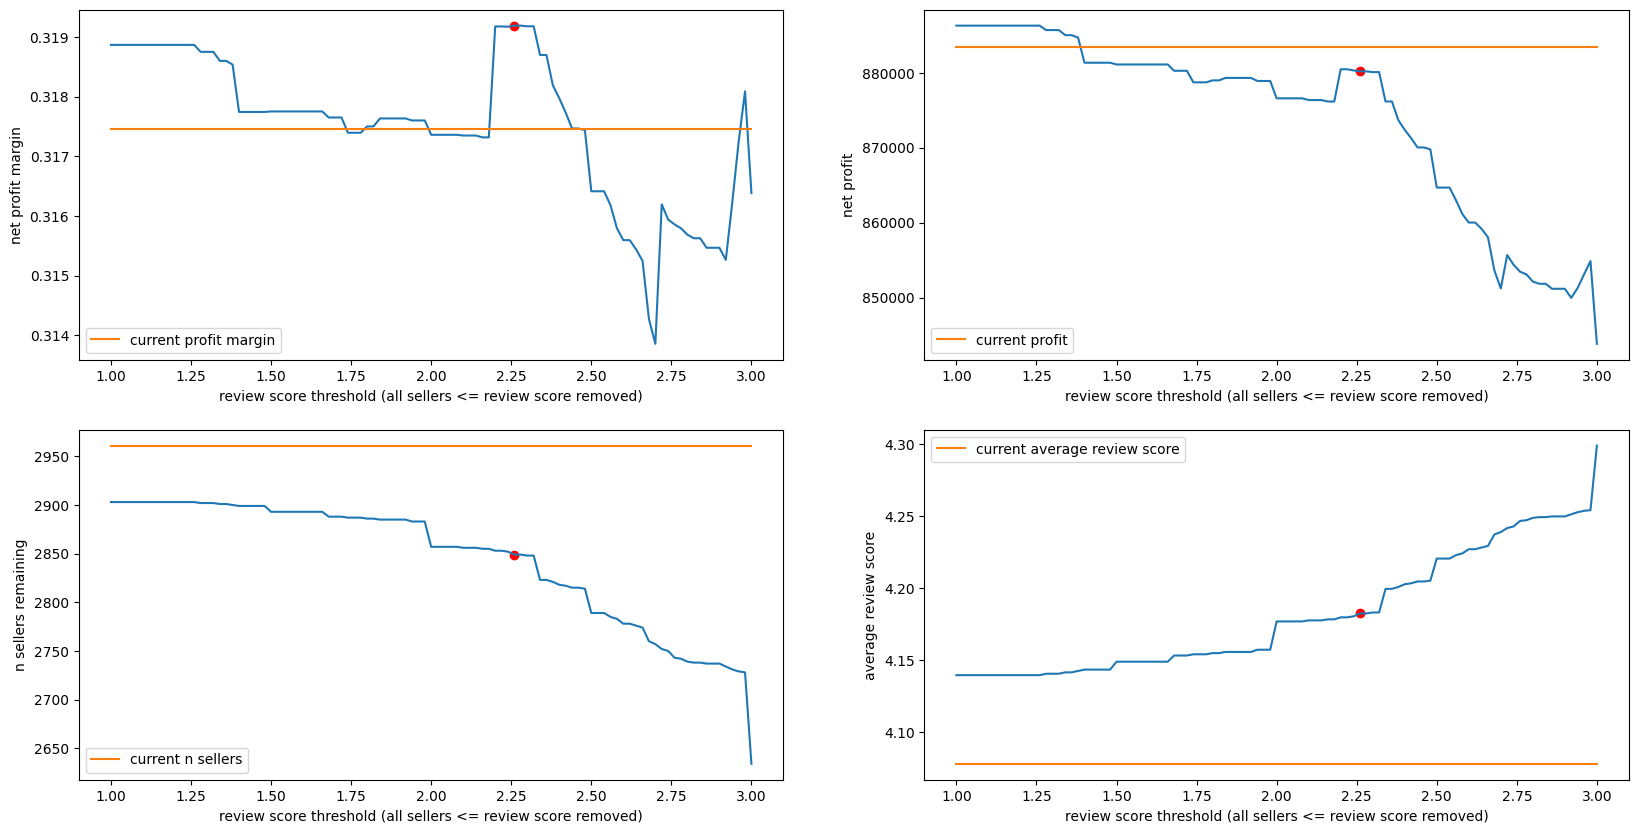

In [291]:
fig, ([ax5, ax6], [ax7, ax8]) = plt.subplots(2, 2, figsize=(20,10))

# plot net profit margin vs. review score threshold
ax5.plot(review_score_threshold, new_profit_margin)
ax5.plot(review_score_threshold, [net_profit / revenue_t]*len(review_score_threshold), label='current profit margin')
ax5.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], max(new_profit_margin), color='red')
ax5.set_xlabel('review score threshold (all sellers <= review score removed)')
ax5.set_ylabel('net profit margin')
ax5.legend(loc='lower left')

# plot net profit vs. review score threshold
ax6.plot(review_score_threshold, new_profit)
ax6.plot(review_score_threshold, [net_profit]*len(review_score_threshold), label='current profit')
ax6.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], new_profit[new_profit_margin.index(max(new_profit_margin))], color='red')
ax6.set_xlabel('review score threshold (all sellers <= review score removed)')
ax6.set_ylabel('net profit')
ax6.legend(loc='lower left')

# plot n sellers remaining vs. review score threshold
ax7.plot(review_score_threshold, n_sellers)
ax7.plot(review_score_threshold, [len(sellers_pl)]*len(review_score_threshold), label='current n sellers')
ax7.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], n_sellers[new_profit_margin.index(max(new_profit_margin))], color='red')
ax7.set_xlabel('review score threshold (all sellers <= review score removed)')
ax7.set_ylabel('n sellers remaining')
ax7.legend(loc='lower left')

# plot new review scores vs. review score threshold
ax8.plot(review_score_threshold, new_review)
ax8.plot(review_score_threshold, [sellers_pl.review_score.mean()]*len(review_score_threshold), label='current average review score')
ax8.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], new_review[new_profit_margin.index(max(new_profit_margin))], color='red')
ax8.set_xlabel('review score threshold (all sellers <= review score removed)')
ax8.set_ylabel('average review score')
ax8.legend(loc='upper left')

plt.show();